In [23]:
%matplotlib inline

import cPickle as pickle
import lda
import matplotlib.pyplot as plt
import numpy as np
import os
from serial_lda_gibbs import LdaSampler
from multicore_lda_gibbs import MulticoreLdaSampler
import time

pickle_filepath = 'baseline_data.pickle'
None

In [9]:
def load_reuters_dataset():
    if not os.path.exists(pickle_filepath):
        dump_reuters_dataset()
    with open(pickle_filepath, 'r') as rfile:
        X, vocab, titles = pickle.load(rfile)
    return X, vocab, titles

def dump_reuters_dataset():
    X = lda.datasets.load_reuters()
    vocab = lda.datasets.load_reuters_vocab()
    titles = lda.datasets.load_reuters_titles()

    with open(pickle_filepath, 'w') as wfile:
        pickle.dump( (X, vocab, titles), wfile)


In [10]:
def serial_gibbs(X, k, iters=50, log=True):
    sampler = LdaSampler(k)
    start = time.time()
    for it, phi in enumerate(sampler.run(X, maxiter=iters)):
        if log:
            print "Iteration", it
            print "Likelihood", sampler.loglikelihood()
        else:
            i = it
    end = time.time()
    print 'Completed %d iterations in %.3f seconds (serial)' % (iters, end - start)
    return sampler


def multicore_gibbs(X, k, p, iters=50, log=True):
    sampler = MulticoreLdaSampler(k, p)
    start = time.time()
    for it, phi in enumerate(sampler.run(X, maxiter=iters)):
        if log:
            print "Iteration", it
            print "Likelihood", sampler.loglikelihood()
        else:
            i = it
    end = time.time()
    print 'Completed %d iterations in %.3f seconds (P=%d)' % (iters, end - start, p)
    return sampler

In [11]:
#https://archive.ics.uci.edu/ml/datasets/Bag+of+Words
def load(dataset):
    files = {
        'nips': 'docword.nips.txt', 
        'nytimes': 'docwords.nytimes.txt',
    }
    if dataset == 'reuters':
        return load_reuters_dataset()
    elif dataset in files: 
        with open(files[dataset], 'r') as rfile:
            lines = rfile.readlines()
        n_documents = int(lines[0])
        n_words = int(lines[1])
        X = np.zeros((n_documents, n_words))
        data = map(lambda s: map(int, s.split()), lines[3:])
        for doc, word, count in data:
            X[doc-1][word-1] = count
        return X
    else:
        raise Exception ('Dataset %s not found' % dataset)


In [7]:
data = load_reuters_dataset()[0]
multicore_gibbs(data, 10, 2,iters=50, log=True)

Sampled in 5.822 seconds
Updated in 0.089 seconds
Iteration 0
Likelihood -861274.727994
Sampled in 4.758 seconds
Updated in 0.072 seconds
Iteration 1
Likelihood -836762.264186
Sampled in 4.853 seconds
Updated in 0.078 seconds
Iteration 2
Likelihood -816237.729073
Sampled in 4.782 seconds
Updated in 0.080 seconds
Iteration 3
Likelihood -797810.404973


KeyboardInterrupt: 

In [12]:
# serial_gibbs(load('nips'), 10, 16)
times = {}
likelihoods = {}
data = load_reuters_dataset()[0]
k = 10
iters=50

sampler = serial_gibbs(data, k, iters=50, log=False)
times[0] = np.mean(sampler.sample_times)
likelihoods[0] = sampler.loglikelihood()
for p in [1,2,4,8,16]:
    sampler = multicore_gibbs(data, k, p,iters=50, log=False)
    times[p] = np.mean(sampler.sample_times) + np.mean(sampler.update_times)
    likelihoods[p] = sampler.loglikelihood()


Sampled in 3.021 seconds
Sampled in 2.982 seconds
Sampled in 3.252 seconds
Sampled in 3.427 seconds
Sampled in 3.142 seconds
Sampled in 2.919 seconds
Sampled in 2.937 seconds
Sampled in 3.005 seconds
Sampled in 3.176 seconds
Sampled in 3.185 seconds
Sampled in 2.951 seconds
Sampled in 3.130 seconds
Sampled in 3.000 seconds
Sampled in 2.904 seconds
Sampled in 3.046 seconds
Sampled in 3.265 seconds
Sampled in 3.070 seconds
Sampled in 3.016 seconds
Sampled in 2.871 seconds
Sampled in 3.020 seconds
Sampled in 3.008 seconds
Sampled in 3.128 seconds
Sampled in 3.082 seconds
Sampled in 3.178 seconds
Sampled in 3.132 seconds
Sampled in 3.147 seconds
Sampled in 3.145 seconds
Sampled in 3.062 seconds
Sampled in 2.898 seconds
Sampled in 2.885 seconds
Sampled in 3.031 seconds
Sampled in 3.114 seconds
Sampled in 3.023 seconds
Sampled in 3.068 seconds
Sampled in 2.957 seconds
Sampled in 3.019 seconds
Sampled in 2.936 seconds
Sampled in 2.984 seconds
Sampled in 2.894 seconds
Sampled in 2.868 seconds


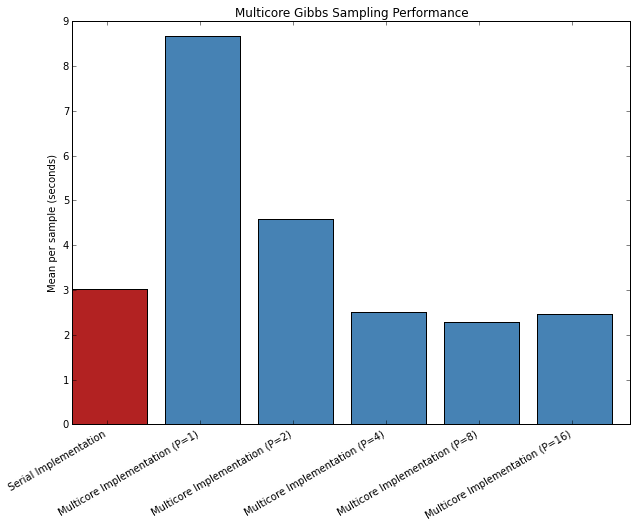

In [47]:
x, y = map(list, zip(*times.items()))
x[0] = 'Serial Implementation'
x[1:] = map(lambda p: 'Multicore Implementation (P=%d)' % p, x[1:])
y = map(abs, y)

fig = plt.figure()
width = .75
ind = np.arange(len(y))
plt.bar(ind[0], y[0], color='firebrick')
plt.bar(ind[1:], y[1:], color='steelblue')

plt.xticks(ind + width / 2, x)
plt.title('Multicore Gibbs Sampling Performance')
plt.ylabel('Mean per sample (seconds)')
fig.autofmt_xdate()
fig.set_size_inches(10, 8)

plt.show()

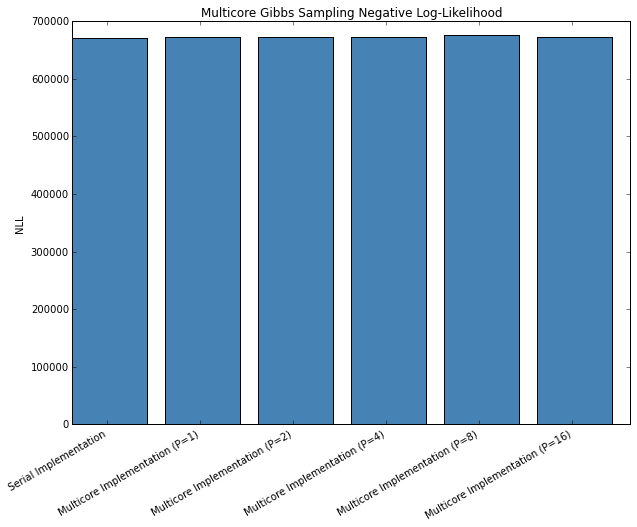

In [50]:
x, y = map(list, zip(*likelihoods.items()))
x[0] = 'Serial Implementation'
x[1:] = map(lambda p: 'Multicore Implementation (P=%d)' % p, x[1:])
y = map(abs, y)

fig = plt.figure()
width = .75
ind = np.arange(len(y))
plt.bar(ind, y, color='steelblue')

plt.xticks(ind + width / 2, x)
plt.title('Multicore Gibbs Sampling Negative Log-Likelihood')
plt.ylabel('NLL')
fig.autofmt_xdate()
fig.set_size_inches(10, 8)

plt.show()

In [54]:
for p, t in times.items():
    print p, abs(t), likelihoods[p]

0 3.02741773129 -671525.40346
1 8.66701588631 -671979.391639
2 4.57691593647 -672320.004321
4 2.51902005196 -673422.372834
8 2.28835065365 -676193.38109
16 2.45646562099 -671795.139852
